<a href="https://colab.research.google.com/github/YIM-GAYUN/2025_Lab_AI-based_thumbnail_automatic_generation/blob/main/lab_finalcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.라이브러리 설치 및 환경설정

In [1]:
!pip install git+https://github.com/openai/CLIP.git  # OpenAI CLIP 설치
!pip install scenedetect
!pip install yt_dlp
!pip install -U openai-whisper

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oa9pj9tq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oa9pj9tq
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.84.0
    Uninstalling openai-1.84.0:
      Successfully uninstalled openai-1.84.0


In [3]:
'''
# keybert 사용시
pip install keybert
pip install sentence-transformers
'''

'\npip install keybert\npip install sentence-transformers\n'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 보안을 위해 api_key는 따로 불러오기
from google.colab import files
files.upload()  # 내 api_key 있는 파일 업로드

#1.사용자 입력

# 2.영상 분석(STT 및 키워드 기반 CLIP)

In [104]:
import os, re, json, cv2, torch, openai, whisper, clip
import torch.nn.functional as F
from PIL import Image
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
from api_key import api_key # api_key 불러오기
# from keybert import KeyBERT

openai.api_key = api_key
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_SCENES = 300
SAMPLES_PER_SCENE = 3
TMP_AUDIO = "_tmp_audio.wav"
OUT_DIR = "keyframes"
os.makedirs(OUT_DIR, exist_ok=True)

print("→ loading Whisper & CLIP …")
whisper_model = whisper.load_model("small", device=DEVICE)
clip_model, clip_pre = clip.load("ViT-B/32", device=DEVICE)
clip_model.eval()


# 동영상 길이 제한 확인
def is_video_within_25_minutes(video_path: str) -> bool:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("동영상을 열 수 없습니다.")
        return False
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration_sec = frame_count / fps
    cap.release()
    return duration_sec <= 1500  # 25분


# 프레임 가져오기
def get_scene_frames(path: str):
    vm = VideoManager([path])
    sm = SceneManager(); sm.add_detector(ContentDetector(threshold=23))
    vm.set_downscale_factor(); vm.start(); sm.detect_scenes(vm)
    scenes = sm.get_scene_list()[:MAX_SCENES]
    vm.release()

    cap, collected = cv2.VideoCapture(path), []
    for s in scenes:
        start, end = s[0].get_frames(), s[1].get_frames()
        for t in torch.linspace(start, end - 1, SAMPLES_PER_SCENE):
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(t.item()))
            ok, frame = cap.read()
            if ok:
                collected.append((int(t.item()), frame))
    cap.release()
    return collected


# STT + 키워드 추출
def whisper_and_sentences(audio: str):
    print("→ Whisper STT …")
    txt = whisper_model.transcribe(audio)["text"]

    '''
    # KeyBERT 추가할 경우
    # KeyBERT 초기화 (한국어 최적화 모델)
    kw_model = KeyBERT(model_name="jhgan/ko-sroberta-multitask")

    # 키워드 추출 파라미터 설정
    keywords = kw_model.extract_keywords(
        txt,
        keyphrase_ngram_range=(1, 2),  # 단일어/2-gram 허용
        stop_words=["입니다", "그리고", "합니다", "하는"],  # 한국어 불용어 리스트
        top_n=6,          # 추출 키워드 수
        diversity=0.7,    # 결과 다양성 제어
        use_mmr=True      # 최대 마진 관련성 알고리즘 적용
    )

    global kws
    kws = [kw[0] for kw in keywords if kw[1] > 0.35]  # 신뢰도 임계값 설정
    '''

    resp = openai.ChatCompletion.create(
        model="gpt-4o-mini", temperature=0.4,
        messages=[
            {"role": "system", "content": "Extract 6 core Korean keywords from the transcript, no numbering."},
            {"role": "user", "content": txt}
        ])
    global kws
    kws = [w.strip() for w in resp.choices[0].message.content.split("\n") if w.strip()]

    vis_prompt = (
        f"For each of these keywords create one short(≤10 words) English visual sentence: {', '.join(kws)}. "
        "Then add three sentences depicting the video host (e.g., 'The host smiles at the camera'). "
        "Return each sentence on a new line in the format <keyword>: <sentence>."
    )
    resp2 = openai.ChatCompletion.create(model="gpt-4o-mini", temperature=0.5,
        messages=[{"role": "user", "content": vis_prompt}])

    lines = [l.strip() for l in resp2.choices[0].message.content.split("\n") if l.strip()]
    pairs = []
    for l in lines:
        if ":" in l:
            kw, sent = l.split(":", 1)
            pairs.append((kw.strip(), sent.strip().strip('"')))
    print("keywords:", kws)
    print("sentence pairs:")
    for kw, s in pairs: print(f"  - {kw} -> {s}")
    return pairs


# clip
def clip_best_per_sentence(frames, pairs):
    sentences = [p[1] for p in pairs]
    txt_tokens = clip.tokenize(sentences).to(DEVICE)
    txt_feats = F.normalize(clip_model.encode_text(txt_tokens), dim=-1)

    used, results = set(), []
    for idx, sent_feat in enumerate(txt_feats):
        best_sim, best_frm, best_id = -1, None, None
        for fid, frm in frames:
            if fid in used:
                continue
            img = clip_pre(Image.fromarray(cv2.cvtColor(frm, cv2.COLOR_BGR2RGB))).unsqueeze(0).to(DEVICE)
            img_feat = F.normalize(clip_model.encode_image(img), dim=-1)
            sim = torch.dot(img_feat.squeeze(), sent_feat).item()
            if sim > best_sim:
                best_sim, best_frm, best_id = sim, frm, fid
        if best_frm is not None:
            used.add(best_id)
            results.append((pairs[idx][0], pairs[idx][1], best_sim, best_id, best_frm))
    return results


def process(video_path: str):
    frames = get_scene_frames(video_path)
    print(f"→ sampled {len(frames)} frames from scenes")

    os.system(f"ffmpeg -y -i {video_path} -vn -ar 16000 -ac 1 -c:a pcm_s16le {TMP_AUDIO}")
    pairs = whisper_and_sentences(TMP_AUDIO)

    matches = clip_best_per_sentence(frames, pairs)

    meta = []
    for i, (kw, sent, sim, fid, frm) in enumerate(matches, 1):
        fname = f"{OUT_DIR}/frame_{i}_{re.sub('[^A-Za-z0-9]', '', kw)}_{sim:.3f}.jpg"
        cv2.imwrite(fname, frm)
        print(f"{fname} (sim={sim:.3f}, frame={fid}) ← {sent}")
        meta.append({"file": fname, "keyword": kw, "sentence": sent, "sim": sim, "frame": fid})

    with open(f"{OUT_DIR}/_meta.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    os.remove(TMP_AUDIO)

# ────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    video_file = input("🎥 동영상 파일 경로를 입력하세요 (예: video.mp4): ").strip()
    if os.path.isfile(video_file):
        if is_video_within_25_minutes(video_file):
            process(video_file)
        else:
            print("동영상이 25분을 초과합니다. 25분 이내 영상만 처리 가능합니다.")
    else:
        print("유효한 동영상 파일 경로가 아닙니다.")


→ loading Whisper & CLIP …
🎥 동영상 파일 경로를 입력하세요 (예: video.mp4): /content/drive/MyDrive/lab2/lab_video_final.mp4


ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 30.000 FPS, resolution: 1280 x 720
INFO:pyscenedetect:Detecting scenes...


→ sampled 216 frames from scenes
→ Whisper STT …
keywords: ['대학, 맛집, 순대국, 카페, 웨이팅, 육회']
sentence pairs:
  - 대학 -> Students gather on campus, chatting and laughing.
  - 맛집 -> A bustling restaurant filled with eager diners.
  - 순대국 -> A steaming bowl of 순대국 is served at the table.
  - 카페 -> A cozy café with patrons sipping coffee and reading.
  - 웨이팅 -> A line of hungry customers waiting outside the restaurant.
  - 육회 -> Fresh 육회 is beautifully plated with vibrant garnishes.
  - Host description -> The host smiles at the camera.
keyframes/frame_1__0.240.jpg (sim=0.240, frame=6819) ← Students gather on campus, chatting and laughing.
keyframes/frame_2__0.272.jpg (sim=0.272, frame=4560) ← A bustling restaurant filled with eager diners.
keyframes/frame_3__0.252.jpg (sim=0.252, frame=1620) ← A steaming bowl of 순대국 is served at the table.
keyframes/frame_4__0.275.jpg (sim=0.275, frame=489) ← A cozy café with patrons sipping coffee and reading.
keyframes/frame_5__0.297.jpg (sim=0.297, frame=145

#3.레이아웃 설정

In [105]:
import os
import random
from PIL import Image
import itertools

FRAME_W, FRAME_H = 1280, 720

image_folder = "/content/keyframes"
num_splits = int(input("분할 개수 (1,2,4): "))
assert num_splits in [1,2,4]

image_paths = [
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith('.jpg')
]
assert len(image_paths) >= num_splits

def get_positions(n):
    if n == 1:
        return [(0, 0, FRAME_W, FRAME_H)]
    if n == 2:
        return [
            (0, 0, FRAME_W//2, FRAME_H),
            (FRAME_W//2, 0, FRAME_W, FRAME_H)
        ]
    if n == 4:
        return [
            (0,              0, FRAME_W//2, FRAME_H//2),
            (FRAME_W//2,     0, FRAME_W,    FRAME_H//2),
            (0,         FRAME_H//2, FRAME_W//2, FRAME_H),
            (FRAME_W//2, FRAME_H//2, FRAME_W,    FRAME_H)
        ]

positions = get_positions(num_splits)

all_perms = list(itertools.permutations(image_paths, num_splits))
selected = random.sample(all_perms, k=min(6, len(all_perms)))

out_dir = f"output_split_{num_splits}"
os.makedirs(out_dir, exist_ok=True)

for idx, perm in enumerate(selected, start=1):
    canvas = Image.new("RGB", (FRAME_W, FRAME_H), (0,0,0))
    for img_path, (x0, y0, x1, y1) in zip(perm, positions):
        img = Image.open(img_path).convert("RGB")
        iw, ih = img.size
        sx, sy = iw/FRAME_W, ih/FRAME_H

        box = (
            int(x0*sx), int(y0*sy),
            int(x1*sx), int(y1*sy)
        )
        patch = img.crop(box)
        patch = patch.resize((x1-x0, y1-y0), Image.LANCZOS)
        canvas.paste(patch, (x0, y0))

    canvas.save(os.path.join(out_dir, f"layout_{idx}.jpg"))

print(f"완료! 랜덤으로 {len(selected)}개 레이아웃이 '{out_dir}' 폴더에 저장되었습니다.")


분할 개수 (1,2,4): 4
완료! 랜덤으로 6개 레이아웃이 'output_split_4' 폴더에 저장되었습니다.


# 4.제목 생성: 키워드 기반 제목 생성

In [106]:
# 올바른 처리 방식 (각 요소를 개별적으로 처리)
kws = [w.strip() for kw in kws for w in kw.split(",")]
print(kws)

['대학', '맛집', '순대국', '카페', '웨이팅', '육회']


In [107]:
import requests
from api_key import youtube_api_key #구글클라우드 youtube_data_v3 api 사용

y_api_key = youtube_api_key
channel_id = "UCmbGE7Y2ov7pTBuUrkXgtTQ"  # 할명수
# channel_id = "UCCZ-gBdN59pF39tbm16xvdQ" # 찰스엔터
# channel_id = "UCoQy2wS5aiKCk-rUXiLS-vQ" # 토모토모

# 1. 채널에서 uploads playlist ID 가져오기
channel_url = f"https://www.googleapis.com/youtube/v3/channels?part=contentDetails&id={channel_id}&key={y_api_key}"
channel_res = requests.get(channel_url).json()
uploads_playlist_id = channel_res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]

# 2. playlist에서 최근 영상 4개 가져오기
videos_url = f"https://www.googleapis.com/youtube/v3/playlistItems?part=snippet&playlistId={uploads_playlist_id}&maxResults=4&key={y_api_key}"
videos_res = requests.get(videos_url).json()
recent_titles = [item["snippet"]["title"] for item in videos_res["items"]]

for i, title in enumerate(recent_titles, 1):
    print(f"{i}. {title}")


1. (ENG) T 심은 데 T 난 아들 버논이와 아들 친구 F 승관이의 세븐틴(SEVENTEEN) 10년치 취중고백 | 할명수 ep.239
2. 뭔 짓을 해도 인성 논란 안 생기는 연예인 #할명수 #박명수 #류경수
3. 박진영 집에서 술 먹다 도망친 박보영 #박보영 #박진영 #류경수
4. 전애인 청첩장 가능? 불가능? #논쟁 #박보영 #박명수


In [114]:
import os
import re
from api_key import api_key

import openai
#openai.api_key = api_key

keywords = kws

# 프롬프트 생성
recent_titles_text = "\n".join([f"{i+1}. {title}" for i, title in enumerate(recent_titles)])
prompt = (
    f"참고할 유튜브 채널의 최근 4개 영상 썸네일 제목은 다음과 같아:\n\n"
    f"{recent_titles_text}\n\n"
    f"위 제목들의 공통 스타일을 분석해서, 아래 키워드를 활용한 유사한 스타일의 썸네일 제목을 2개 생성해줘. 뒤에 부제목이나 해시태그가 있다면 생략해줘.\n\n"
    f"키워드: {keywords}\n\n"
    "키워드는 영어지만 한글로 번역해서 활용해도 좋아. 제목은 무조건 8글자 이하로, 구어체에 가깝고 재치 있고 MZ스러운 느낌으로 작성해줘."
    "너무 무겁지 않게, 자연스럽게 부탁해. 생성된 제목 뒤에 이모지나 이모티콘, 특수기호가 있다면 전부 삭제해줘."
    "제목은 문자열을 큰따옴표로 감싸서 생성해줘."
)

# GPT 호출
response = openai.ChatCompletion.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "너는 유튜브 썸네일의 제목 제작 전문가야."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.7,
    top_p=1,
    seed=122,
)

# 결과 출력
response_text = response.choices[0].message.content
print("🔹 GPT 응답:\n", response_text)

# 제목 추출
titles = re.findall(r"^\d+\.\s*(.+)", response_text, re.MULTILINE)
titles = [title.strip() for title in titles]
print("📌 생성된 제목:", ", ".join(titles))


🔹 GPT 응답:
 1. "순대국 맛집 탐방"
2. "웨이팅 없는 육회"
📌 생성된 제목: "순대국 맛집 탐방", "웨이팅 없는 육회"


# 5.제목 이미지 생성

In [115]:
# 할명수
import os
from PIL import Image, ImageDraw, ImageFont

# 저장 경로 설정 및 폴더 생성
save_path = "/content/title_img"
os.makedirs(save_path, exist_ok=True)  # 폴더가 없으면 생성

font_path = "/content/drive/MyDrive/lab2/font/KOTRA_LEAP.ttf"
font_size = 90
bg_color = (0, 0, 0, 0)
font_color_left = "#00FFCC"
font_color_right = "#0AE159"
outline_color = "black"
outline_width = 8
letter_spacing = -1

titles = [title.strip('"') for title in titles]

for i, title in enumerate(titles):
    # 1. 타이틀을 마지막 공백 기준으로 분리
    if ' ' in title:
        left_text, right_text = title.rsplit(' ', 1)
    else:
        left_text, right_text = title, ''

    img = Image.new("RGBA", (1200, 220), bg_color)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, font_size)

    # 2. 각 부분의 폭 계산
    def text_width(text):
        width = 0
        for char in text:
            bbox = draw.textbbox((0, 0), char, font=font)
            width += bbox[2] - bbox[0]
        width += letter_spacing * (len(text) - 1) if len(text) > 1 else 0
        return width

    left_width = text_width(left_text)
    right_width = text_width(right_text)
    space_bbox = draw.textbbox((0, 0), " ", font=font)
    space_width = space_bbox[2] - space_bbox[0] if right_text else 0
    total_width = left_width + space_width + right_width

    # 3. 중앙 정렬 위치 계산
    x = (img.width - total_width) // 2
    y = (img.height - font_size) // 2

    # 4. 아래쪽 1/3 검정색 사각형 배경
    rect_height = font_size // 3
    rect_top = y + font_size - rect_height
    rect_bottom = y + font_size + 10
    draw.rectangle(
        [(x, rect_top), (x + total_width, rect_bottom)],
        fill="black"
    )

    # 5. 왼쪽 텍스트 그리기
    for idx, char in enumerate(left_text):
        # 외곽선
        for dx in range(-outline_width, outline_width + 1):
            for dy in range(-outline_width, outline_width + 1):
                if dy > 0 and abs(dx) <= outline_width * 2 and dy <= outline_width * 3:
                    draw.text((x + dx, y + dy), char, font=font, fill=outline_color)
                elif dx*dx + dy*dy <= outline_width*outline_width:
                    draw.text((x + dx, y + dy), char, font=font, fill=outline_color)
        # 본문
        draw.text((x, y), char, font=font, fill=font_color_left)
        bbox = draw.textbbox((0, 0), char, font=font)
        x += (bbox[2] - bbox[0]) + letter_spacing

    # 6. 공백 추가
    if right_text:
        x += space_width

    # 7. 오른쪽 텍스트 그리기
    for idx, char in enumerate(right_text):
        # 외곽선
        for dx in range(-outline_width, outline_width + 1):
            for dy in range(-outline_width, outline_width + 1):
                if dy > 0 and abs(dx) <= outline_width * 2 and dy <= outline_width * 3:
                    draw.text((x + dx, y + dy), char, font=font, fill=outline_color)
                elif dx*dx + dy*dy <= outline_width*outline_width:
                    draw.text((x + dx, y + dy), char, font=font, fill=outline_color)
        # 본문
        draw.text((x, y), char, font=font, fill=font_color_right)
        bbox = draw.textbbox((0, 0), char, font=font)
        x += (bbox[2] - bbox[0]) + letter_spacing

    img.save(f"{save_path}/hms_title_{i+1}.png")

In [77]:
# 찰스엔터

from PIL import Image, ImageDraw, ImageFont

# 저장 경로 설정 및 폴더 생성
save_path = "/content/title_img"
os.makedirs(save_path, exist_ok=True)  # 폴더가 없으면 생성

font_path = "/content/drive/MyDrive/lab2/font/Cafe24Classictype-v1.1.ttf"
font_size = 90
bg_color = (0, 0, 0, 0)
font_color = "pink"
outline_color = "black"
outline_width = 10  # 외곽선 더 두껍게
shadow_color = (0, 0, 0, 180)  # 반투명 검정
letter_spacing = -1

titles = [title.strip('"') for title in titles]

for i, title in enumerate(titles):
    img = Image.new("RGBA", (1200, 220), bg_color)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, font_size)

    # 텍스트 폭 계산 함수
    def text_width(text):
        width = 0
        for char in text:
            bbox = draw.textbbox((0, 0), char, font=font)
            width += bbox[2] - bbox[0]
        width += letter_spacing * (len(text) - 1) if len(text) > 1 else 0
        return width

    total_width = text_width(title)
    x = (img.width - total_width) // 2
    y = (img.height - font_size) // 2

    # 외곽선
    outline_pos = x
    for char in title:
        bbox = draw.textbbox((0, 0), char, font=font)
        for dx in range(-outline_width, outline_width+1):
            for dy in range(-outline_width, outline_width+1):
                if dx*dx + dy*dy <= outline_width*outline_width:
                    draw.text((outline_pos + dx, y + dy), char, font=font, fill=outline_color)
        outline_pos += (bbox[2] - bbox[0]) + letter_spacing

    # 본문
    text_pos = x
    for char in title:
        bbox = draw.textbbox((0, 0), char, font=font)
        draw.text((text_pos, y), char, font=font, fill=font_color)
        text_pos += (bbox[2] - bbox[0]) + letter_spacing

    img.save(f"{save_path}/CE_title_{i+1}.png")


In [98]:
# 토모토모

from PIL import Image, ImageDraw, ImageFont

# 저장 경로 설정 및 폴더 생성
save_path = "/content/title_img"
os.makedirs(save_path, exist_ok=True)  # 폴더가 없으면 생성

font_path = "/content/drive/MyDrive/lab2/font/Dobong_Cultural_Routes(TTF).ttf"
font_size = 100
bg_color = (0, 0, 0, 0)
font_color = "green"
outline_color = "white"
outline_width = 4  # 외곽선 더 두껍게
shadow_offset = (0, 6)  # 아래쪽 그림자
shadow_color = (0, 0, 0, 180)  # 반투명 검정
letter_spacing = -2

titles = [title.strip('"') for title in titles]

for i, title in enumerate(titles):
    img = Image.new("RGBA", (1200, 220), bg_color)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, font_size)

    # 텍스트 폭 계산 함수
    def text_width(text):
        width = 0
        for char in text:
            bbox = draw.textbbox((0, 0), char, font=font)
            width += bbox[2] - bbox[0]
        width += letter_spacing * (len(text) - 1) if len(text) > 1 else 0
        return width

    total_width = text_width(title)
    x = (img.width - total_width) // 2
    y = (img.height - font_size) // 2

    # 1. 그림자(아래쪽에만)
    shadow_x, shadow_y = x + shadow_offset[0], y + shadow_offset[1]
    shadow_pos = shadow_x
    for char in title:
        bbox = draw.textbbox((0, 0), char, font=font)
        draw.text((shadow_pos, shadow_y), char, font=font, fill=shadow_color)
        shadow_pos += (bbox[2] - bbox[0]) + letter_spacing

    # 2. 외곽선
    outline_pos = x
    for char in title:
        bbox = draw.textbbox((0, 0), char, font=font)
        for dx in range(-outline_width, outline_width+1):
            for dy in range(-outline_width, outline_width+1):
                if dx*dx + dy*dy <= outline_width*outline_width:
                    draw.text((outline_pos + dx, y + dy), char, font=font, fill=outline_color)
        outline_pos += (bbox[2] - bbox[0]) + letter_spacing

    # 3. 본문
    text_pos = x
    for char in title:
        bbox = draw.textbbox((0, 0), char, font=font)
        draw.text((text_pos, y), char, font=font, fill=font_color)
        text_pos += (bbox[2] - bbox[0]) + letter_spacing

    img.save(f"{save_path}/tomo_title_{i+1}.png")


#6.썸네일 생성: 썸네일 레이아웃 + 제목 -> 완성하기


 배경 이미지 미리보기


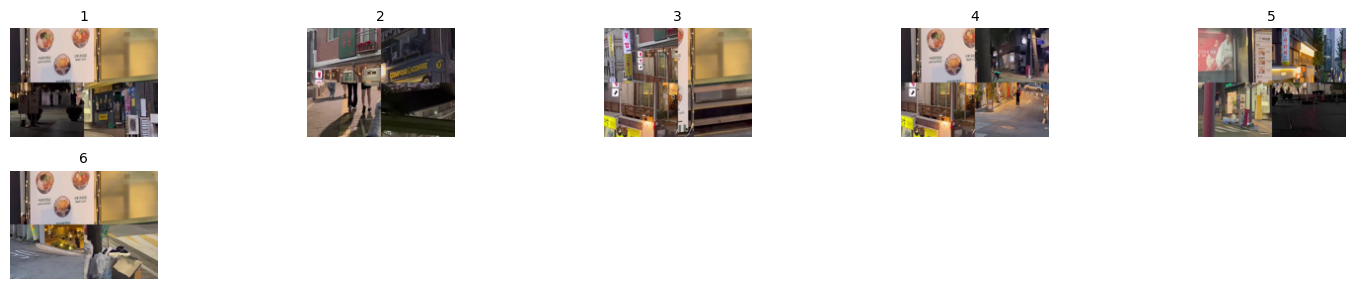

------------------

 텍스트 이미지 미리보기


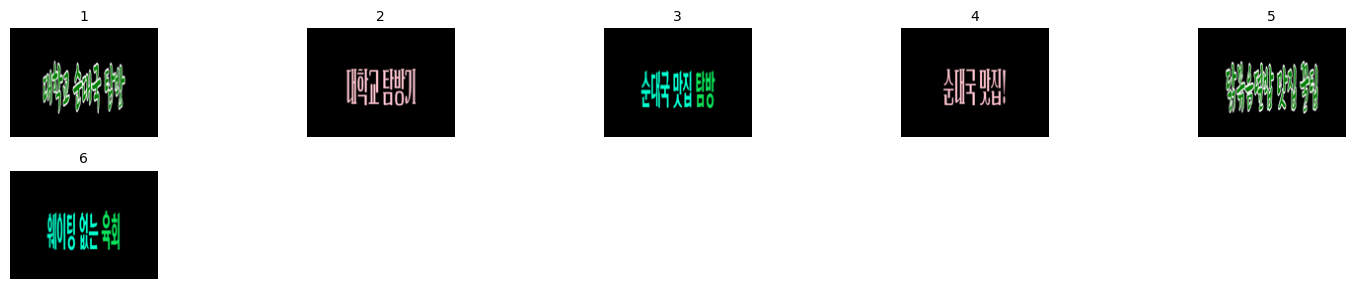

------------------


In [116]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_image_grid(image_dir, file_list, title, cols=5, thumb_size=(150, 110)):
    print(f"\n {title}")
    plt.figure(figsize=(15, len(file_list) // cols + 2))
    for idx, file in enumerate(file_list):
        img_path = os.path.join(image_dir, file)
        img = Image.open(img_path).convert("RGB").resize(thumb_size)
        plt.subplot((len(file_list) + cols - 1) // cols, cols, idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{idx+1}", fontsize=10)
    plt.tight_layout()
    plt.show()

# 디렉토리 설정
bg_dir = "/content/output_split_4"
text_dir = "/content/title_img"

# 이미지 파일 불러오기
bg_files = [f for f in os.listdir(bg_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
text_files = [f for f in os.listdir(text_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# 썸네일 미리보기 출력
show_image_grid(bg_dir, bg_files, "배경 이미지 미리보기")
print('------------------')
show_image_grid(text_dir, text_files, "텍스트 이미지 미리보기")
print('------------------')

In [100]:
# 이미지 선택하기 (인풋으로 받기)
bg_idx = int(input("🖼️ 사용할 배경 이미지 번호를 입력하세요: ")) - 1
text_idx = int(input("📝 사용할 텍스트 이미지 번호를 입력하세요: ")) - 1

# 선택한 경로
bg_path = os.path.join(bg_dir, bg_files[bg_idx])
text_path = os.path.join(text_dir, text_files[text_idx])

🖼️ 사용할 배경 이미지 번호를 입력하세요: 1
📝 사용할 텍스트 이미지 번호를 입력하세요: 1


In [101]:
from PIL import Image

# 이미지 열기
bg_img = Image.open(bg_path).convert("RGBA")
text_img = Image.open(text_path).convert("RGBA")

# 텍스트 이미지 크기
tw, th = text_img.size

# 배경 이미지 크기
bw, bh = bg_img.size

# 가운데 위치 계산
x = (bw - tw) // 2
y = (bh - th) // 2

# 텍스트 이미지를 배경에 붙이기
bg_img.paste(text_img, (x, y), mask=text_img)

# 저장할 경로
output_path = "/content/output_combined.png"
bg_img.save(output_path)

# 결과 보여주기
bg_img.show()
print(f"✅ 저장 완료: {output_path}")


✅ 저장 완료: /content/output_combined.png
